In [1]:
import os
import numpy as np
import matlab.engine
import scipy.sparse as sparse
import nibabel as nib
from joblib import Parallel, delayed
import scipy.io as sio
import scipy.sparse as sp
import scipy.sparse.csgraph as csgraph
from scipy.sparse import csr_matrix, coo_matrix
from gdist import compute_gdist
import time

In [8]:
def compute_mesh_area(gifti_surf, PF=False):
    """
    Compute the surface area of a triangle mesh.

    Parameters:
    M (dict or np.ndarray): A dictionary with 'vertices' (mx3) and 'faces' (nx3) as keys 
                            or a 3xm array of edge distances.
    PF (bool): If True, return the surface area per face. Default is False.

    Returns:
    float or np.ndarray: Total surface area or an array of areas per face.
    """
    # Extract vertices and faces
    vertices, faces = gifti_surf.darrays[0].data, gifti_surf.darrays[1].data

    # Compute edge lengths of each triangle
    A = np.linalg.norm(vertices[faces[:, 1], :] - vertices[faces[:, 0], :], axis=1)
    B = np.linalg.norm(vertices[faces[:, 2], :] - vertices[faces[:, 1], :], axis=1)
    C = np.linalg.norm(vertices[faces[:, 2], :] - vertices[faces[:, 0], :], axis=1)

    # Heron's formula for area
    s = (A + B + C) / 2
    area = np.sqrt(s * (s - A) * (s - B) * (s - C))

    return np.sum(area) if not PF else area


def compute_mesh_adjacency(gifti_surf):
    """
    Compute the adjacency matrix of a triangle mesh.

    Parameters:
    gifti_surf (nibabel.gifti.GiftiImage): GiftiImage object containing the mesh data.

    Returns:
    scipy.sparse matrix: Adjacency matrix as a sparse [vxv] array.
    """
    faces = gifti_surf.darrays[1].data
    N = faces.max() + 1
    rows = np.hstack((faces[:, 0], faces[:, 0], faces[:, 1], faces[:, 1], faces[:, 2], faces[:, 2]))
    cols = np.hstack((faces[:, 1], faces[:, 2], faces[:, 0], faces[:, 2], faces[:, 0], faces[:, 1]))
    data = np.ones(len(rows), dtype=int)
    A = sp.coo_matrix((data, (rows, cols)), shape=(N, N))

    return A.astype(bool)


def compute_mesh_distances(vertices, faces, order=1):
    """
    Compute the distance matrix of a triangle mesh from a nibabel gifti object.

    Parameters:
    gifti_surf (nibabel.gifti.GiftiImage): GiftiImage object containing the mesh data.
    order (int): 0 for adjacency matrix, 1 for first-order, 2 for second-order distance matrix.

    Returns:
    scipy.sparse.csr_matrix: Distance matrix.
    """
    if order > 2:
        raise ValueError("High order distance matrix not handled.")

    # Adjacency matrix
    if order == 0:
        return compute_mesh_adjacency(gifti_surf)

    # Calculate distances for each edge in each triangle
    # Adjusting the calculation to match MATLAB behavior
    d0 = vertices[faces[:, 0], :] - vertices[faces[:, 1], :]
    d1 = vertices[faces[:, 1], :] - vertices[faces[:, 2], :]
    d2 = vertices[faces[:, 2], :] - vertices[faces[:, 0], :]
    distances = np.sqrt(np.sum(np.vstack([d0, d1, d2]) ** 2, axis=1))

    # Construct row and column indices
    row_ind = np.hstack([faces[:, 0], faces[:, 1], faces[:, 2]])
    col_ind = np.hstack([faces[:, 1], faces[:, 2], faces[:, 0]])

    D = csr_matrix((distances, (row_ind, col_ind)), shape=(vertices.shape[0], vertices.shape[0]))
    D = (D + D.T) / 2

    if order == 1:
        return D

    # Second order distance matrix
    D2 = D.copy()
    for i in range(vertices.shape[0]):
        a = D2[i, :].nonzero()[1]
        for b in a:
            c = D2[b, :].nonzero()[1]
            D[i, c] = np.minimum(D[i, c], D2[i, b] + D2[b, c])

    return D




def compute_geodesic_distances(vertices, faces, source_indices, max_dist=np.inf):
    """
    Compute geodesic distances on a mesh.

    Parameters:
    vertices (numpy.ndarray): Array of mesh vertices.
    faces (numpy.ndarray): Array of mesh faces.
    source_indices (numpy.ndarray): Indices of source vertices.
    max_dist (float): Maximum distance for geodesic computation.

    Returns:
    numpy.ndarray: Geodesic distances from source vertices.
    """
    D = compute_mesh_distances(vertices, faces)
    
    dist = np.full(vertices.shape[0], np.inf)
    for src in source_indices:
        dist[src] = 0.0

    remaining = np.arange(vertices.shape[0])
    while remaining.size > 0:
        u = remaining[np.argmin(dist[remaining])]
        if dist[u] > max_dist:
            break
        remaining = remaining[remaining != u]
        for v in D.indices[D.indptr[u]:D.indptr[u+1]]:
            alt = dist[u] + D.data[D.indptr[u]:D.indptr[u+1]][D.indices[D.indptr[u]:D.indptr[u+1]] == v]
            if alt < dist[v]:
                dist[v] = alt

    return dist


def compute_smoothed_matrices(meshname, fwhm, n_layers, redo=False):
    gifti_surf = nib.load(meshname)
    vertices = gifti_surf.darrays[0].data
    faces = gifti_surf.darrays[1].data
    Ns = vertices.shape[0]
    Ns_per_layer = Ns // n_layers
    vertspace = np.mean(np.sqrt(compute_mesh_area(gifti_surf, PF=True)))
    
    smoothmeshname = os.path.join(os.path.dirname(meshname), f'FWHM{fwhm:3.2f}_{os.path.basename(meshname)}.mat')
    if os.path.exists(smoothmeshname) and not redo:
        return smoothmeshname

    if fwhm > vertspace * 100 or fwhm < vertspace / 100:
        raise ValueError('Mismatch between FWHM and mesh units')
        
    sigma2 = (fwhm / 2.355) ** 2

    # Initialize lists to store COO matrix components
    rows_list, cols_list, data_list = [], [], []

    def process_layer(l):
        for j in range(Ns_per_layer):
            source_indices = np.array([l * Ns_per_layer + j])            
            dist = compute_geodesic_distances(vertices, faces, source_indices, max_dist=fwhm)
            mask = dist <= fwhm
            q = np.exp(-(dist[mask] ** 2) / (2 * sigma2))
            q /= np.sum(q)
            
            # Store row, column, and data information for COO matrix
            rows_list.extend(np.full(sum(mask), l * Ns_per_layer + j))
            cols_list.extend(np.where(mask)[0])
            data_list.extend(q)

    Parallel(n_jobs=-1)(delayed(process_layer)(l) for l in range(n_layers))

    # Create QG as a COO matrix and then convert it to CSR format
    QG = coo_matrix((data_list, (rows_list, cols_list)), shape=(Ns, Ns)).tocsr()

    sio.savemat(smoothmeshname, {'QG': QG, 'M': gifti_surf}, do_compression=True)

    return smoothmeshname, QG

In [9]:
t0 = time.time()
smoothmeshname, QG2 = compute_smoothed_matrices('/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/multilayer.2.ds.link_vector.gii', 5.0, 2)
t1 = time.time()
total = t1-t0
print(f'{total} seconds')

TypeError: Could not convert None (type <class 'NoneType'>) to array

In [4]:
meshname='/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/multilayer.2.ds.link_vector.gii'
fwhm=5.0
n_layers=2

gifti_surf = nib.load(meshname)
vertices = gifti_surf.darrays[0].data
faces = gifti_surf.darrays[1].data
Ns = vertices.shape[0]
Ns_per_layer = Ns // n_layers
vertspace = np.mean(np.sqrt(compute_mesh_area(gifti_surf, PF=True)))

smoothmeshname = os.path.join(os.path.dirname(meshname), f'FWHM{fwhm:3.2f}_{os.path.basename(meshname)}.mat')

if fwhm > vertspace * 100 or fwhm < vertspace / 100:
    raise ValueError('Mismatch between FWHM and mesh units')

sigma2 = (fwhm / 2.355) ** 2
QG = sp.lil_matrix((Ns, Ns))

l=0
#def process_layer(l):
QGl = sp.lil_matrix((Ns, Ns_per_layer))
j=0
#    for j in range(Ns_per_layer):
source_indices = np.array([l * Ns_per_layer + j])
dist = compute_geodesic_distances(vertices, faces, source_indices, max_dist=fwhm)

In [5]:
dist[0:20]

array([0.        , 1.70707333, 3.47912872, 4.58544552,        inf,
              inf,        inf, 5.77762938, 1.60122454,        inf,
       2.56376362, 2.00182366,        inf, 4.45750996,        inf,
              inf,        inf, 6.79675457, 5.92219687,        inf])

In [42]:
dist2 = compute_mesh_geodesic(gifti_surf, source_indices, max_dist=fwhm)

In [43]:
dist2[0:10]

array([0.        , 1.70707333, 3.41414666, 4.52046347,        inf,
              inf,        inf, 6.69915557, 1.60122454,        inf])

In [25]:
np.min(faces[:])

0

In [80]:
source_indices

array([-82359], dtype=int32)

In [ ]:
d = distances[0, :]
useind = d <= fwhm
print(np.where(useind)[0])

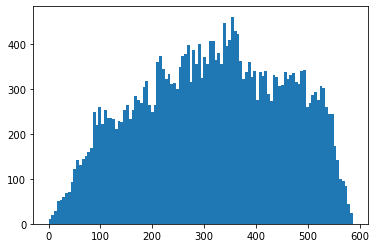

In [125]:
import matplotlib.pyplot as plt
_=plt.hist(distances[~np.isinf(distances)],110)

In [126]:
distances

array([[         inf,          inf,          inf, ...,          inf,
                 inf, 190.88475031]])

In [7]:
N[1,0]

1

In [8]:
np.sqrt(np.sum(np.power(gifti_surf.darrays[0].data[0,:]-gifti_surf.darrays[0].data[1,:],2)))

1.7070733

In [57]:
import numpy as np
import nibabel as nib
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

def build_adjacency_matrix(gifti_surf):
    """
    Build an adjacency matrix from a nibabel gifti object.

    Parameters:
    gifti_surf (nibabel.gifti.GiftiImage): GiftiImage object containing the mesh data.

    Returns:
    scipy.sparse.csr_matrix: Adjacency matrix as a sparse matrix.
    """
    faces = gifti_surf.darrays[1].data
    n_vertices = gifti_surf.darrays[0].data.shape[0]

    # Build sparse adjacency matrix
    row_ind = np.hstack([faces[:, 0], faces[:, 1], faces[:, 2]])
    col_ind = np.hstack([faces[:, 1], faces[:, 2], faces[:, 0]])
    data = np.ones(len(row_ind), dtype=np.float32)

    adjacency_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(n_vertices, n_vertices))
    adjacency_matrix = adjacency_matrix + adjacency_matrix.T  # Ensure symmetry
    adjacency_matrix[adjacency_matrix > 1] = 1  # Remove duplicate edges

    return adjacency_matrix

def compute_geodesic_distances(gifti_surf):
    """
    Compute geodesic distances for each vertex to every other vertex.

    Parameters:
    gifti_surf (nibabel.gifti.GiftiImage): GiftiImage object containing the mesh data.

    Returns:
    numpy.ndarray: Matrix of geodesic distances.
    """
    adjacency_matrix = build_adjacency_matrix(gifti_surf)

    # Compute geodesic distances using Dijkstra's algorithm
    distances, _ = dijkstra(adjacency_matrix, return_predecessors=True, directed=False, unweighted=False)

    return distances

def compute_geodesic_distances_batch(gifti_surf, batch_size=1000):
    """
    Compute geodesic distances for each vertex to every other vertex in batches.

    Parameters:
    gifti_surf (nibabel.gifti.GiftiImage): GiftiImage object containing the mesh data.
    batch_size (int): Number of vertices to process in each batch.

    Returns:
    numpy.ndarray: Matrix of geodesic distances.
    """
    adjacency_matrix = build_adjacency_matrix(gifti_surf)
    n_vertices = adjacency_matrix.shape[0]
    distances = np.zeros((n_vertices, n_vertices))

    for i in range(0, n_vertices, batch_size):
        end = min(i + batch_size, n_vertices)
        batch_distances, _ = dijkstra(adjacency_matrix, indices=range(i, end), return_predecessors=True, directed=False, unweighted=False)
        distances[i:end, :] = batch_distances

    return distances

# Example usage
# gifti_surf = nib.load('path_to_your_gifti_file.gii')
# geodesic_distances = compute_geodesic_distances_batch(gifti_surf)


# Example usage
gifti_surf = nib.load('/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/multilayer.2.ds.link_vector.gii')
geodesic_distances = compute_geodesic_distances_batch(gifti_surf)

MemoryError: Unable to allocate 202. GiB for an array with shape (164716, 164716) and data type float64

In [50]:
gifti_surf.darrays[0].data.shape

(164716, 3)

In [51]:
gifti_surf = nib.load('/home/bonaiuto/Dropbox/Projects/inProgress/auditory_laminar/derivatives/processed/sub-104/surf/pial.ds.gii')
gifti_surf.darrays[0].data.shape

(53425, 3)

In [52]:
gifti_surf = nib.load('/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/pial.gii')
gifti_surf.darrays[0].data.shape

(507832, 3)

In [56]:
ds_gifti_surf = nib.load('/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/pial.ds.gii')
ds_gifti_surf.darrays[0].data.shape[0]/gifti_surf.darrays[0].data.shape[0]

0.16217568014619008

In [10]:
out_dir='./test_output'
subj_id='sub-104'
subject_out_dir = os.path.join(out_dir, subj_id)
parasite = matlab.engine.start_matlab()

In [11]:
##
# Step 1) Invert the subject's data. This step only has to be done once
## 

# Subject fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# T1
mri_fname = '/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_data/spm/sub-104/s2023-02-28_13-33-133958-00001-00224-1.nii'

mesh_fname = '/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/multilayer.2.ds.link_vector.gii'

# Data file to base simulations on
data_file='/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_data/processed/sub-104/ses-01/spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
coreg_fname='/home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/test_output/sub-104/inv/multilayer.2.ds.link_vector.spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
patch_size=5
n_temp_modes = 4
woi=[0, 1000]
n_layers=2

parasite.invert_ebb(data_file, coreg_fname, mri_fname, mesh_fname, nas, lpa, rpa, patch_size, n_temp_modes, woi, n_layers, nargout=0)

MatlabExecutionError: 
  File /home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/spm_eeg_smoothmesh_full_multilayer_mm.m, line 34, in spm_eeg_smoothmesh_full_multilayer_mm

  File /home/bonaiuto/Dropbox/Projects/software/MEGsurfer/python/invert_ebb.m, line 10, in invert_ebb
Output argument "QG_layers" (and maybe others) not assigned during call to "spm_eeg_smoothmesh_full_multilayer_mm>makeF%1/F%".


In [ ]:
function simlayer_free_energy(subj_info, session_num, invfoi, SNR, varargin)
% SIMLAYER_FREE_ENERGY  Run simulations with whole brain - free energy
%   analysis
%
% Use as
%   simlayer_free_energy(subjects(1), 1, [10 30], -20)
% where the first argument is the subject info structure (from create_subjects),
% the second is the session number, the third is the frequency range, and
% the fourth is the SNR (db).
% 
%   simlayer_free_energy(...,'param','value','param','value'...) allows
%    additional param/value pairs to be used. Allowed parameters:
%    * surf_dir - directory containing subject surfaces
%    * mri_dir - directory containing subject MRIs
%    * out_file - output file name (automatically generated if not
%    specified)
%    * dipole_moment - 10 (default) or interger - moment of simulated
%    dipole
%    * sim_patch_size - 5 (default) or interger - simulated patch size
%    * reconstruct_patch_size - 5 (default) or interger - reconstruction patch size
%    * nsims - 60 (default) or integer - number of simulations per surface

% Parse inputs
defaults = struct('surf_dir', 'd:\pred_coding\surf', 'mri_dir', 'd:\pred_coding\mri',...
    'out_file', '', 'dipole_moment', 10, 'sim_patch_size', 5,...
    'reconstruct_patch_size', 5, 'nsims', 60);  %define default values
params = struct(varargin{:});
for f = fieldnames(defaults)',
    if ~isfield(params, f{1}),
        params.(f{1}) = defaults.(f{1});
    end
end

% Copy already-inverted file
rawfile=fullfile('d:/pred_coding/analysis/',subj_info.subj_id,...
    num2str(session_num), 'grey_coreg\EBB\p0.4\instr\f15_30',...
    sprintf('br%s_%d.mat',subj_info.subj_id,session_num));
% Output directory
out_path=fullfile('c:/layer_sim/results',subj_info.subj_id,num2str(session_num));
if exist(out_path,'dir')~=7
    mkdir(out_path);
end
% New file to work with
newfile=fullfile(out_path, sprintf('%s_%d.mat',subj_info.subj_id,session_num));

if length(params.out_file)==0
    params.out_file=sprintf('allcrossF_f%d_%d_SNR%d_dipolemoment%d.mat',...
        invfoi(1),invfoi(2),SNR,params.dipole_moment);
end

spm('defaults', 'EEG');
spm_jobman('initcfg'); 

% Copy file to foi_dir
clear jobs
matlabbatch=[];
matlabbatch{1}.spm.meeg.other.copy.D = {rawfile};
matlabbatch{1}.spm.meeg.other.copy.outfile = newfile;
spm_jobman('run', matlabbatch);

% White and pial meshes for this subject
allmeshes=strvcat(fullfile(params.surf_dir,[subj_info.subj_id subj_info.birth_date '-synth'],'surf','ds_white.hires.deformed.surf.gii'),...
    fullfile(params.surf_dir,[subj_info.subj_id subj_info.birth_date '-synth'],'surf','ds_pial.hires.deformed.surf.gii'));
Nmesh=size(allmeshes,1);

% Create smoothed meshes
for meshind=1:Nmesh,
    [smoothkern]=spm_eeg_smoothmesh_mm(deblank(allmeshes(meshind,:)),params.sim_patch_size);
end

%% Setup simulation - number of sources, list of vertices to simulate on
mesh_one=gifti(allmeshes(1,:));
nverts=size(mesh_one.vertices,1);
rng(0);
simvertind=randperm(nverts); %% random list of vertex indices to simulate sources on
Nsim=params.nsims; %% number of simulated sources

%% for MSP  or GS or ARD
% Number of patches as priors
Npatch=round(Nsim*1.5);
% so use all vertices that will be simulated on (plus a few more) as MSP priors
Ip=simvertind(1:Npatch);

% Save priors
patchfilename=fullfile(out_path, 'temppatch.mat');
save(patchfilename,'Ip');

% Inversion method to use
methodnames={'EBB','IID','COH','MSP'}; %% just 1 method for now
Nmeth=length(methodnames);

% Inversion parameters
invwoi=[100 500];
% Number of cross validation folds
Nfolds=1;
% Percentage of test channels in cross validation
ideal_pctest=0;
% Use all available spatial modes
ideal_Nmodes=[];


% All F values
allcrossF=zeros(Nmesh,Nsim,Nmesh,Nmeth);
allcrossVE=zeros(Nmesh,Nsim,Nmesh,Nmeth);

regfiles={};
spatialmodesnames={};

for meshind=1:Nmesh,
    regfile=fullfile(out_path, sprintf('%s_%d_%dcoreg.mat',subj_info.subj_id,session_num,meshind));
    regfiles{meshind}=regfile;
    if exist(regfile,'file')~=2
        clear jobs
        matlabbatch=[];
        matlabbatch{1}.spm.meeg.other.copy.D = {rawfile};
        matlabbatch{1}.spm.meeg.other.copy.outfile = regfile;
        spm_jobman('run', matlabbatch);
        
        % Coregister simulated dataset to reconstruction mesh
        matlabbatch=[];
        matlabbatch{1}.spm.meeg.source.headmodel.D = {regfile};
        matlabbatch{1}.spm.meeg.source.headmodel.val = 1;
        matlabbatch{1}.spm.meeg.source.headmodel.comment = '';
        matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.mri = {fullfile(params.mri_dir,[subj_info.subj_id subj_info.birth_date], [subj_info.headcast_t1 ',1'])};
        matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.cortex = {deblank(allmeshes(meshind,:))};
        matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.iskull = {''};
        matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.oskull = {''};
        matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.scalp = {''};
        matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshres = 2;
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(1).fidname = 'nas';
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(1).specification.type = subj_info.nas;
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(2).fidname = 'lpa';
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(2).specification.type = subj_info.lpa;
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(3).fidname = 'rpa';
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(3).specification.type = subj_info.rpa;
        matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.useheadshape = 0;
        matlabbatch{1}.spm.meeg.source.headmodel.forward.eeg = 'EEG BEM';
        matlabbatch{1}.spm.meeg.source.headmodel.forward.meg = 'Single Shell';            
        spm_jobman('run', matlabbatch);                   
    end
    % Setup spatial modes for cross validation
    spatialmodesname=fullfile(out_path, sprintf('%d_testmodes.mat',meshind));    
    [spatialmodesname,Nmodes,pctest]=spm_eeg_inv_prep_modes_xval(regfile, ideal_Nmodes, spatialmodesname, Nfolds, ideal_pctest);
    spatialmodesnames{meshind}=spatialmodesname;
end


% Simulate sources on each mesh
for simmeshind=1:Nmesh, %% choose mesh to simulate on
    
    simmesh=deblank(allmeshes(simmeshind,:));
    
    %% coregister to correct mesh
    filename=deblank(newfile);
    matlabbatch=[];
    matlabbatch{1}.spm.meeg.source.headmodel.D = {filename};
    matlabbatch{1}.spm.meeg.source.headmodel.val = 1;
    matlabbatch{1}.spm.meeg.source.headmodel.comment = '';
    matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.mri = {fullfile(params.mri_dir,[subj_info.subj_id subj_info.birth_date], [subj_info.headcast_t1 ',1'])};
    matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.cortex = {simmesh};
    matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.iskull = {''};
    matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.oskull = {''};
    matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshes.custom.scalp = {''};
    matlabbatch{1}.spm.meeg.source.headmodel.meshing.meshres = 2;
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(1).fidname = 'nas';
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(1).specification.type = subj_info.nas;
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(2).fidname = 'lpa';
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(2).specification.type = subj_info.lpa;
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(3).fidname = 'rpa';
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.fiducial(3).specification.type = subj_info.rpa;
    matlabbatch{1}.spm.meeg.source.headmodel.coregistration.coregspecify.useheadshape = 0;
    matlabbatch{1}.spm.meeg.source.headmodel.forward.eeg = 'EEG BEM';
    matlabbatch{1}.spm.meeg.source.headmodel.forward.meg = 'Single Shell';
    spm_jobman('run', matlabbatch);
    
    Dmesh=spm_eeg_load(filename);    
    
    %% now simulate sources on this mesh
    for s=1:Nsim,
        %% get location to simulate dipole on this mesh
        simpos=Dmesh.inv{1}.mesh.tess_mni.vert(simvertind(s),:); 
        prefix=sprintf('sim_mesh%d_source%d',simmeshind,s);

        % Simulate source 
        matlabbatch=[];
        matlabbatch{1}.spm.meeg.source.simulate.D = {filename};
        matlabbatch{1}.spm.meeg.source.simulate.val = 1;
        matlabbatch{1}.spm.meeg.source.simulate.prefix = prefix;
        matlabbatch{1}.spm.meeg.source.simulate.whatconditions.all = 1;
        matlabbatch{1}.spm.meeg.source.simulate.isinversion.setsources.woi = invwoi;
        matlabbatch{1}.spm.meeg.source.simulate.isinversion.setsources.isSin.foi = mean(invfoi);
        matlabbatch{1}.spm.meeg.source.simulate.isinversion.setsources.dipmom = [params.dipole_moment params.sim_patch_size];
        matlabbatch{1}.spm.meeg.source.simulate.isinversion.setsources.locs = simpos;
        if abs(params.dipole_moment)>0
            matlabbatch{1}.spm.meeg.source.simulate.isSNR.setSNR = SNR;               
        else
            matlabbatch{1}.spm.meeg.source.simulate.isSNR.whitenoise = 100;
        end
        [a,b]=spm_jobman('run', matlabbatch);
        
        %% now reconstruct onto all the meshes and look at cross val and F vals
        for meshind=1:Nmesh,
        
            % Copy forward model from pial or white coregistered file
            simfilename=fullfile(out_path,sprintf('%s%s_%d.mat',prefix,subj_info.subj_id,session_num));
            sim=load(simfilename);
            reconcoreg=load(regfiles{meshind});
            sim.D.other=reconcoreg.D.other;
            D=sim.D;
            copyfile(fullfile(out_path, sprintf('SPMgainmatrix_%s_%d_%dcoreg_1.mat', subj_info.subj_id, session_num, meshind)), fullfile(out_path, sprintf('SPMgainmatrix_%s%s_%d_1.mat', prefix, subj_info.subj_id, session_num)));
            D.other.inv{1}.gainmat=sprintf('SPMgainmatrix_%s%s_%d_1.mat', prefix, subj_info.subj_id, session_num);
            save(simfilename,'D');
    
            % Resconstruct using each method
            for methind=1:Nmeth,                
                
                % Do inversion of simulated data with this surface
                matlabbatch=[];
                matlabbatch{1}.spm.meeg.source.invertiter.D = {simfilename};
                matlabbatch{1}.spm.meeg.source.invertiter.val = 1;
                matlabbatch{1}.spm.meeg.source.invertiter.whatconditions.all = 1;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.invfunc = 'Classic';
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.invtype = methodnames{methind}; %;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.woi = invwoi;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.foi = invfoi;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.hanning = 1;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.isfixedpatch.fixedpatch.fixedfile = {patchfilename}; % '<UNDEFINED>';
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.isfixedpatch.fixedpatch.fixedrows = 1; %'<UNDEFINED>';
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.patchfwhm =[-params.reconstruct_patch_size]; %% NB A fiddle here- need to properly quantify
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.mselect = 0;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.nsmodes = Nmodes;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.umodes = {spatialmodesnames{simmeshind}};
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.ntmodes = [];
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.priors.priorsmask = {''};
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.priors.space = 1;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.restrict.locs = zeros(0, 3);
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.restrict.radius = 32;
                matlabbatch{1}.spm.meeg.source.invertiter.isstandard.custom.outinv = '';
                matlabbatch{1}.spm.meeg.source.invertiter.modality = {'All'};
                matlabbatch{1}.spm.meeg.source.invertiter.crossval = [pctest Nfolds];                                
                [a1,b1]=spm_jobman('run', matlabbatch);
                
                % Load inversion - get cross validation error end F
                Drecon=spm_eeg_load(simfilename);                
                allcrossF(simmeshind,s,meshind,methind)=Drecon.inv{1}.inverse.crossF;
                allcrossVE(simmeshind,s,meshind,methind)=Drecon.inv{1}.inverse.VE;
                
                
            end
        end
        close all;
    end
end
save(fullfile(out_path,params.out_file),'allcrossF','allcrossVE');


